In [9]:
import cv2 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

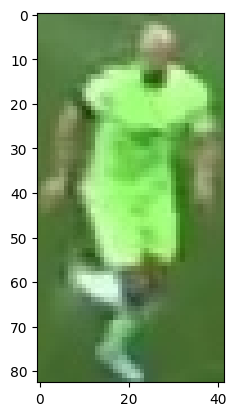

In [10]:
img = cv2.imread('../croppedimg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

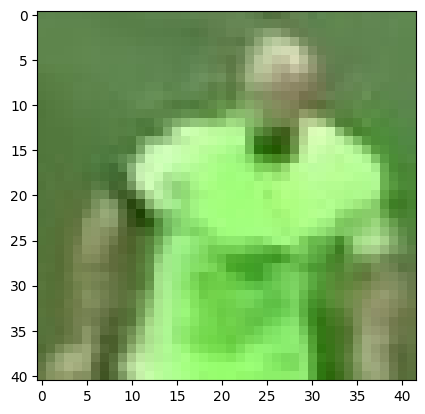

In [11]:
top_half_img = img[0:img.shape[0]//2, 0:img.shape[1]]
plt.imshow(top_half_img)

In [32]:
image_2d = top_half_img.reshape(-1, 3)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1)
kmeans.fit(image_2d)

labels = kmeans.labels_
center_clusters = kmeans.cluster_centers_

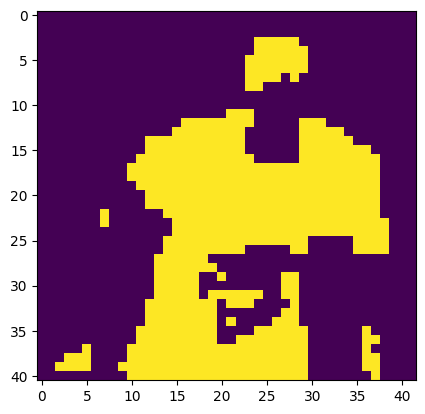

In [33]:
# show the image after clustering
clustred_image = labels.reshape(top_half_img.shape[0], top_half_img.shape[1])
plt.imshow(clustred_image)

In [34]:
corner_cluster = [clustred_image[0,0], clustred_image[0,-1], clustred_image[-1,0], clustred_image[-1,-1]]
corner_cluster
non_player = max(set(corner_cluster), key=corner_cluster.count)
player = 1 - non_player
player

1

In [35]:
center_clusters[player]

array([159.12014134, 229.56713781, 126.9664311 ])